In [1]:
import sys

sys.path.append("../")

import requests
import geojson
import matplotlib.pyplot as plt
import geopandas as gpd
from pathlib import Path
from utils.geojson import load_geojson

/Users/ajalsingh/git/race-line-optimser/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Scrape track data

In [2]:
# Directory to save track data
OUTPUT_DIR = Path("../track_data")
OUTPUT_DIR.mkdir(exist_ok=True)

In [3]:
# Define Overpass API endpoint
OVERPASS_URL = "https://overpass-api.de/api/interpreter"

# List of F1 tracks to query
TRACKS = [
    {"name": "Circuit de Monaco", "type": "relation"},
    {"name": "Silverstone International", "type": "relation"},
    {"name": "Circuit de Spa Francorchamps", "type": "relation"},
    {"name": "Autodromo Nazionale di Monza", "type": "relation"},
    {"name": "Circuit of the Americas", "type": "relation"},
]

In [4]:
def query_overpass(track_name, track_type):
    """
    Query the Overpass API for a specific track.
    """
    query = f"""
    [out:json];
    {track_type}["name"="{track_name}"];
    out body;
    >;
    out skel qt;
    """
    response = requests.get(OVERPASS_URL, params={"data": query})
    response.raise_for_status()
    return response.json()


def remove_pit_lane(data):
    members = data["elements"][0]["members"]
    pit_lane_ref_id = 0

    for member in members:
        if member["role"] == "pit_lane":
            pit_lane_ref_id = member["ref"]
            break

    elements_excluding_pit_lane = [
        el for el in data["elements"] if el["id"] != pit_lane_ref_id
    ]
    data["elements"] = elements_excluding_pit_lane
    return data


def convert_to_geojson(elements):
    """
    Convert Overpass API elements to GeoJSON format.
    """
    features = []
    nodes = {el["id"]: el for el in elements if el["type"] == "node"}

    for el in elements:
        if el["type"] == "way" and "nodes" in el:
            coordinates = [
                [nodes[node_id]["lon"], nodes[node_id]["lat"]]
                for node_id in el["nodes"]
                if node_id in nodes
            ]
            geometry = {
                "type": "LineString",
                "coordinates": coordinates,
            }
            features.append({"type": "Feature", "geometry": geometry, "properties": {}})

    return {"type": "FeatureCollection", "features": features}


def save_geojson(track_name, data):
    """
    Save the track data to a GeoJSON file.
    """
    filename = OUTPUT_DIR / f"{track_name.replace(' ', '_')}.geojson"
    geojson_data = convert_to_geojson(data.get("elements", []))

    with open(filename, "w") as file:
        geojson.dump(geojson_data, file, indent=2)
    print(f"Saved GeoJSON for {track_name} to {filename}")


# Fetch data for all F1 tracks and save them as GeoJSON.

for track in TRACKS:
    print(f"Fetching data for {track['name']}...")
    data = query_overpass(track["name"], track["type"])
    data = remove_pit_lane(data)
    save_geojson(track["name"], data)

Fetching data for Circuit de Monaco...
Saved GeoJSON for Circuit de Monaco to ../track_data/Circuit_de_Monaco.geojson
Fetching data for Silverstone International...
Saved GeoJSON for Silverstone International to ../track_data/Silverstone_International.geojson
Fetching data for Circuit de Spa Francorchamps...
Saved GeoJSON for Circuit de Spa Francorchamps to ../track_data/Circuit_de_Spa_Francorchamps.geojson
Fetching data for Autodromo Nazionale di Monza...
Saved GeoJSON for Autodromo Nazionale di Monza to ../track_data/Autodromo_Nazionale_di_Monza.geojson
Fetching data for Circuit of the Americas...
Saved GeoJSON for Circuit of the Americas to ../track_data/Circuit_of_the_Americas.geojson


### Visualise tracks

In [5]:
# Directory containing the GeoJSON files
TRACK_DIR = Path("../track_data")

Visualizing Autodromo_Nazionale_di_Monza...
Visualizing Silverstone_International...
Visualizing Circuit_of_the_Americas...
Visualizing Circuit_de_Monaco...
Visualizing Circuit_de_Spa_Francorchamps...


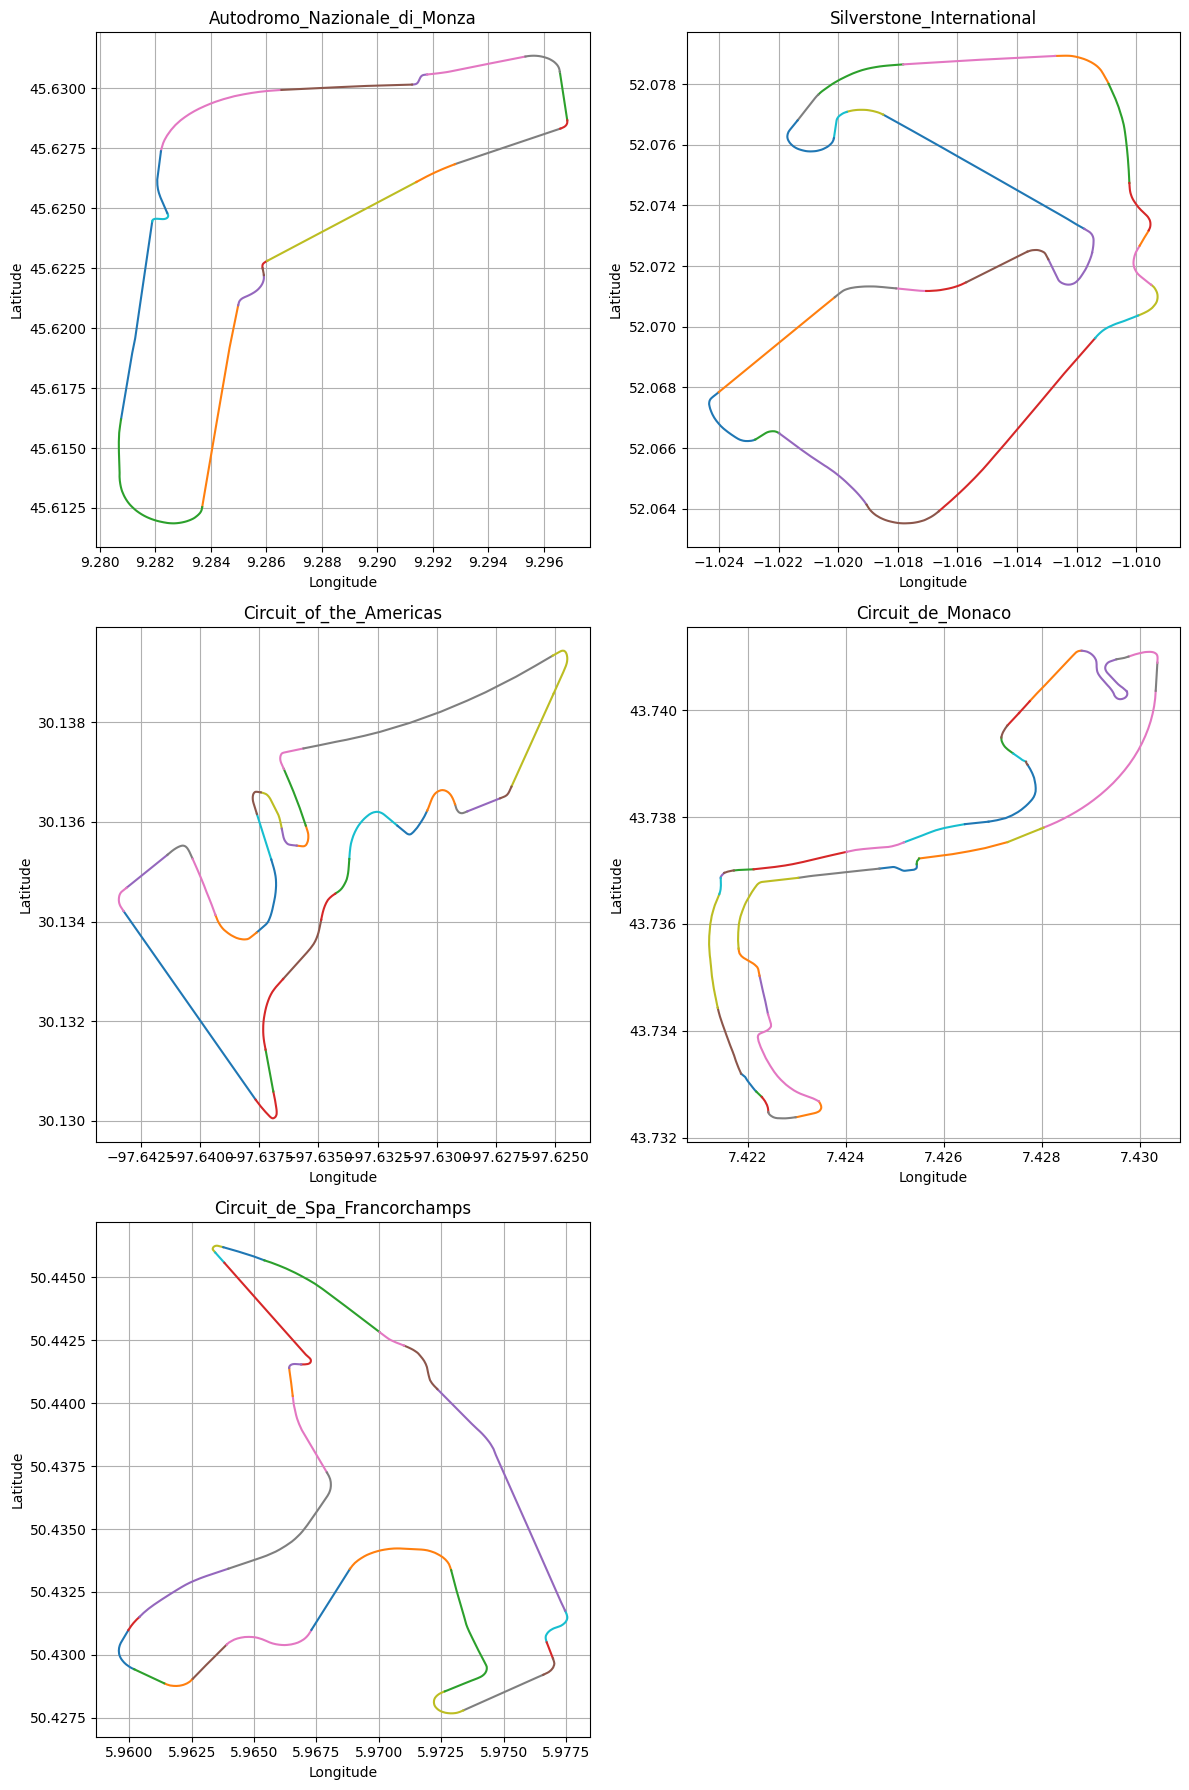

In [6]:
file_paths = list(TRACK_DIR.glob("*.geojson"))
num_files = len(file_paths)
cols = 2
rows = (num_files + 1) // cols  # Calculate rows needed for the grid

fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 6))
axes = axes.flatten()  # Flatten the axes for easy iteration

for idx, file_path in enumerate(file_paths):
    ax = axes[idx]
    print(f"Visualizing {file_path.stem}...")
    geometries = load_geojson(file_path)
    for geom in geometries:
        if geom.geom_type == "LineString":
            x, y = geom.xy
            ax.plot(x, y, label=file_path.stem)
        elif geom.geom_type == "MultiLineString":
            for line in geom.geoms:
                x, y = line.xy
                ax.plot(x, y, label=file_path.stem)

    ax.set_title(file_path.stem)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)

# Hide unused subplots if the number of files is less than rows * cols
for idx in range(len(file_paths), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()